# NearPy
---
## Download Dataset

In [1]:
%pip install numpy h5py requests NearPy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libraries
import numpy as np
import h5py
import os
import requests
import tempfile
import time
import tqdm

import nearpy
import matplotlib.pyplot as plt

## Download Dataset
---

In [3]:
response = requests.get("http://ann-benchmarks.com/sift-128-euclidean.hdf5")
loc = "sift.hdf5"
with open(loc, 'wb') as f:
    f.write(response.content)

sift_h5py = h5py.File(loc, "r")

In [4]:
list(sift_h5py.keys())

['distances', 'neighbors', 'test', 'train']

In [5]:
dataset = sift_h5py['train']
queries = sift_h5py['test'][:100]
print(dataset.shape)
print(queries.shape)

(1000000, 128)
(100, 128)


In [6]:
print(sift_h5py.get("neighbors").shape)
print(sift_h5py.get("train").shape)
print(sift_h5py.get("test").shape)

(10000, 100)
(1000000, 128)
(10000, 128)


## Building a NearPy Engine
---

In [7]:
# Dimension of our vector space
dimension = 128

In [8]:
normalized_dataset = dataset / np.linalg.norm(dataset, axis=1)[:, np.newaxis]

# Create a random binary hash with 10 bits
rbp = nearpy.hashes.RandomBinaryProjections('rbp', 10)

In [9]:
# Create a NearPy engine with pipeline configuration
engine = nearpy.Engine(dimension, lshashes=[rbp], distance=nearpy.distances.EuclideanDistance())

In [10]:
# Store base vectors in engine
for idx, vec in enumerate(dataset):
    engine.store_vector(vec, idx)

In [11]:
def compute_recall(neighbors, true_neighbors):
    total = 0
    for gt_row, row in zip(true_neighbors, neighbors):
        total += np.intersect1d(gt_row, row).shape[0]
    return total / true_neighbors.size

In [12]:
# Perform similarity search on each query vector
nearest_neighbors = []
start = time.time()
for qidx, query in enumerate(queries):
    #nearest_neighbors.append(engine.neighbours(query))
    
    # Print the nearest neighbours for each query vector
    nearest_neighbor = engine.neighbours(query)
    #print(f"Query Index: {qidx}")
    for neighbor in nearest_neighbor:
        neighbor_vec = neighbor[0]
        neighbor_index = neighbor[1]
        neighbor_distance = neighbor[2]
        # print(f"Index: {neighbor_index}, Distance: {neighbor_distance}")
    print()
end = time.time()
print("Time: ", end - start)





































































































Time:  7.548264503479004


In [13]:
# Parameter comparison: hash bit length variation
bitlengths = range(1, 21)
times = []
for bitlength in bitlengths:
    print(f"Hash bucket length: {bitlength} bits")
    rbp = nearpy.hashes.RandomBinaryProjections('rbp', bitlength)
    engine = nearpy.Engine(dimension, lshashes=[rbp], distance=nearpy.distances.EuclideanDistance())
    for idx, vec in enumerate(dataset):
        engine.store_vector(vec, idx)
        
    nearest_neighbors = []
    start = time.time()
    for qidx, query in enumerate(queries):
        nearest_neighbors.append(engine.neighbours(query))
    end = time.time()
    print("Time: ", end - start)
    times.append(end-start)

Hash bucket length: 1 bits
Time:  156.46125411987305
Hash bucket length: 2 bits
Time:  182.294775724411
Hash bucket length: 3 bits
Time:  69.01358985900879
Hash bucket length: 4 bits
Time:  63.12382912635803
Hash bucket length: 5 bits
Time:  36.04390335083008
Hash bucket length: 6 bits
Time:  35.05176258087158
Hash bucket length: 7 bits
Time:  21.137805223464966
Hash bucket length: 8 bits
Time:  12.21573805809021
Hash bucket length: 9 bits
Time:  5.2380781173706055
Hash bucket length: 10 bits
Time:  4.07000732421875
Hash bucket length: 11 bits
Time:  3.9085042476654053
Hash bucket length: 12 bits
Time:  2.8937034606933594
Hash bucket length: 13 bits
Time:  2.3417694568634033
Hash bucket length: 14 bits
Time:  3.3752152919769287
Hash bucket length: 15 bits
Time:  1.3884296417236328
Hash bucket length: 16 bits
Time:  0.7827067375183105
Hash bucket length: 17 bits
Time:  0.25902318954467773
Hash bucket length: 18 bits
Time:  0.4921915531158447
Hash bucket length: 19 bits
Time:  0.39796543

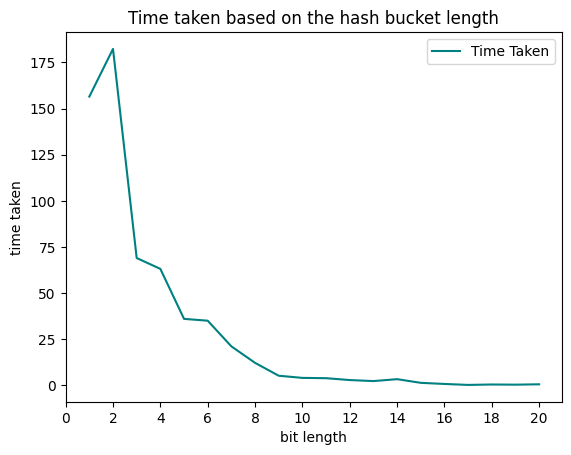

In [17]:
plt.plot(bitlengths, times, color='teal', label='Time Taken')
plt.legend()
plt.title("Time taken based on the hash bucket length")
plt.xlabel('bit length')
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.ylabel('time taken')
plt.show()